In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [44]:
#Data inserting

df = pd.read_csv('/Users/Downloads/mental health survey/train.csv')  #data upload
df.info()          # Displays column names, data types, and non-null counts
df.shape           # Displays number of rows & columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

(140700, 20)

In [45]:
# Define target variable
target = 'Depression'

# Split into features and target
X = df.drop(columns=[target])
y = df[target]

In [46]:
#data cleaning

##Find any missing values

df.isnull().sum()


id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [47]:
# Filling the missing values 
df.fillna({
    'Profession': 'Unknown',
    'Academic Pressure': df['Academic Pressure'].median(),
    'Work Pressure': df['Work Pressure'].median(),
    'CGPA': df['CGPA'].median(),
    'Study Satisfaction': df['Study Satisfaction'].median(),
    'Job Satisfaction': df['Job Satisfaction'].median(),
    'Dietary Habits': df['Dietary Habits'].mode()[0],
    'Degree': 'Unknown',
    'Financial Stress': df['Financial Stress'].median(),
}, inplace=True)

In [48]:
df.isnull().sum() #secondary check to confirm there is no null value

id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [49]:
#Identifying the numerical columns 
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

#normalising the numerical features using the MinMaxScaler for Deep learning
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [50]:
#Identifying the categorical columns and then performing the one-hot coding
df.select_dtypes(include=['object']).columns

Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')

In [51]:
#applying the one-hot coding
df_encoded=pd.get_dummies(df, columns=['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],drop_first=True)

In [52]:
#Splitting data as train and validation
from sklearn.model_selection import train_test_split  #importing sklearn and split libraries

X_train, X_val, y_train, y_val = train_test_split( 
    X, y, 
    test_size=0.2,   #to have 20% of train data for validation/test
    random_state=42, 
    stratify=y
)

In [53]:
# checking if the split has been applied properly by analysing the sets Val and train 

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (112560, 19)
X_val shape: (28140, 19)
y_train shape: (112560,)
y_val shape: (28140,)


In [54]:
overlap = np.intersect1d(X_train.index, X_val.index) # to ensure there is no overlapping of the same row in both train & val
print("Number of overlapping rows:", len(overlap))
print(numeric_columns)

Number of overlapping rows: 0
Index(['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress', 'Depression'],
      dtype='object')


In [55]:
#fitting and preprocessing the data 

numeric_columns = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress']
categorical_columns = [
    'Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'
]

In [56]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # fill numeric NaNs with median
    ('scaler', MinMaxScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill NaNs with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [57]:
X_train_processed = preprocessor.fit_transform(X_train)    #preparing raw data into input features (X,X)
X_val_processed = preprocessor.transform(X_val)
print(np.isnan(X_train_processed).sum())  # should now be 0 which means there is no nan in the X_train_processed

0


In [58]:
import torch

X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)           # Convert processed numpy arrays to tensors
X_val_tensor = torch.tensor(X_val_processed, dtype=torch.float32)
                                                                               
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)       # Convert target variables (Series) to tensors
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)


In [59]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_val_tensor.shape)
print(y_val_tensor.shape)

torch.Size([112560, 702])
torch.Size([112560, 1])
torch.Size([28140, 702])
torch.Size([28140, 1])


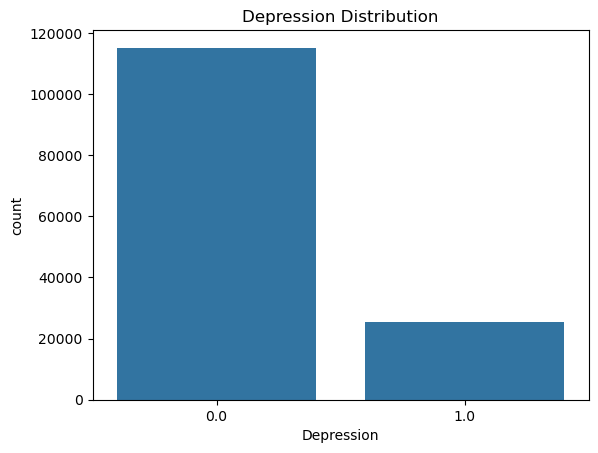

In [60]:
#performing EDA 

#using seaborn to find how many people comes in which depression 

sns.countplot(x='Depression', data=df)
plt.title('Depression Distribution')
plt.show()

In [61]:
# The above states the data is highly imbalanced with 110000-25000 ratio, which is too much 

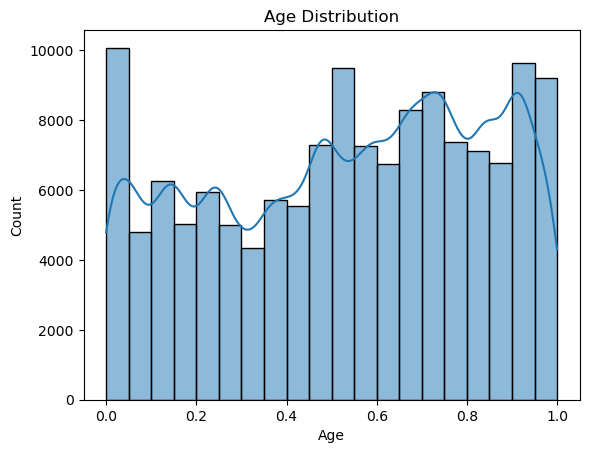

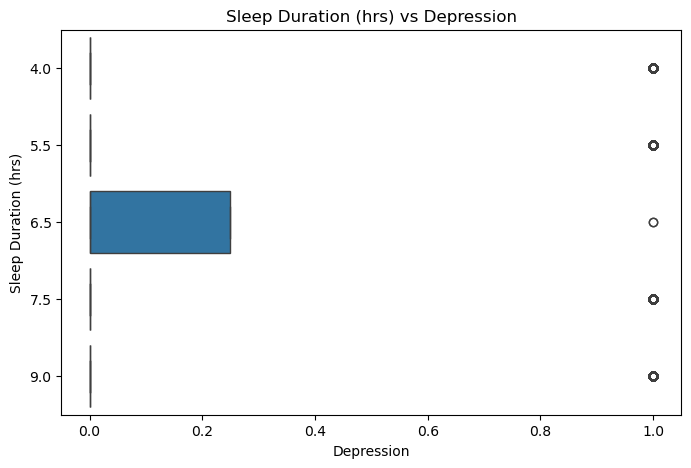

In [62]:
sns.histplot(df['Age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

sleep_mapping = {                      #making sleep duration as numerical data instead of onehot encoded as it shows random colmns which makes data to interpret difficult
    'Less than 5 hours': 4,
    '5-6 hours': 5.5,
    '6-7 hours': 6.5,
    '7-8 hours': 7.5,
    'More than 8 hours': 9
}
df['Sleep Duration (hrs)'] = df['Sleep Duration'].map(sleep_mapping)

plt.figure(figsize=(8,5))
sns.boxplot(x='Depression', y='Sleep Duration (hrs)', data=df, orient='h')
plt.title('Sleep Duration (hrs) vs Depression')
plt.show()


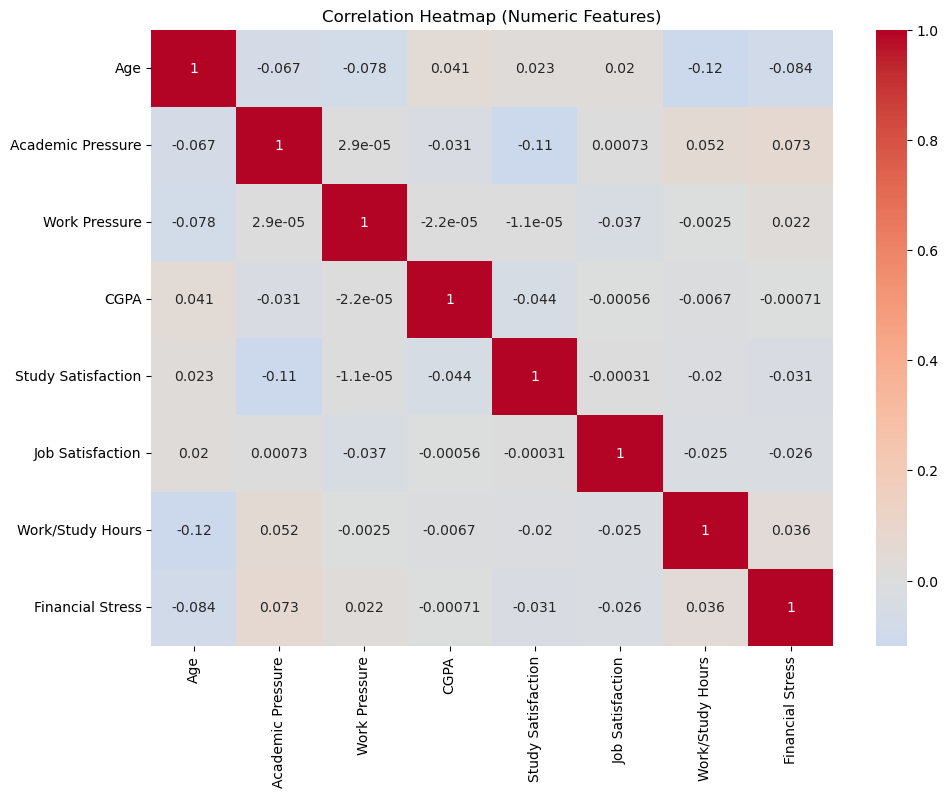

In [63]:
#correlation heatmap only for numeric data
plt.figure(figsize=(11,8))
sns.heatmap(df[numeric_columns].corr(), cmap='coolwarm', center=0, annot=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [64]:
#defining a base line(benchmark) using logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Logistic Regression baseline model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_processed, y_train)

# Predictions
y_pred = log_reg.predict(X_val_processed)

# Evaluation
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9388415067519545
Precision: 0.8440162271805274
Recall: 0.8138079405437121
F1 Score: 0.828636861495569
Confusion Matrix:
 [[22258   769]
 [  952  4161]]


In [65]:
# Interpretation of the baseline evaluation has good accuracy, precision and recall, an F1 score of .8 and low false positives and negatives

#we can still aim for a better recall by making we tunings so to make it more precise so that the model does not miss the depressed minority individual


In [66]:
# performing class weight balance to minimise the wrong classification of minority
log_reg = LogisticRegression(max_iter=1000, class_weight ='balanced')
log_reg.fit(X_train_processed, y_train)

#tuning the threshold to increase the recall so that more depressed will be identified
y_proba = log_reg.predict_proba(X_val_processed)[:, 1]
y_pred_custom = (y_proba >= 0.45).astype(int)  # lower threshold for higher recall

print("Accuracy:", accuracy_score(y_val, y_pred_custom))
print("Precision:", precision_score(y_val, y_pred_custom))
print("Recall:", recall_score(y_val, y_pred_custom))
print("F1 Score:", f1_score(y_val, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_custom))

Accuracy: 0.9099147121535182
Precision: 0.6848293662173789
Recall: 0.9340895755916292
F1 Score: 0.7902705385951849
Confusion Matrix:
 [[20829  2198]
 [  337  4776]]


AUC Score: 0.9733


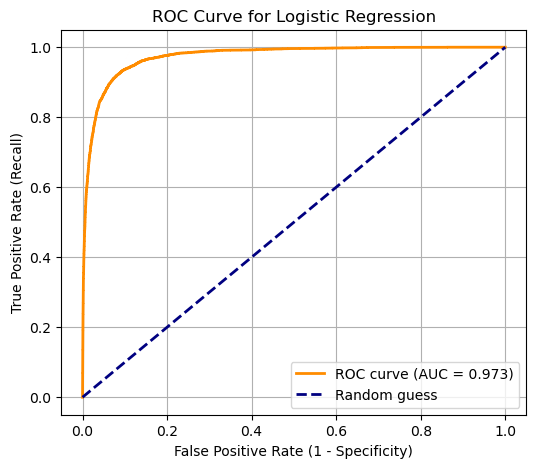

In [67]:
# performing ROC curve to find the optimum threshold 
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = log_reg.predict_proba(X_val_processed)[:, 1]    # to get positive case probalitiy
fpr, tpr, thresholds = roc_curve(y_val, y_proba)    # ROC curve points 
auc = roc_auc_score(y_val, y_proba)
print(f"AUC Score: {auc:.4f}")   # AUC score

#plot AUC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [68]:
from numpy import argmax

# Calculate Youden's J statistic = tpr - fpr
J = tpr - fpr
best_idx = argmax(J)
best_threshold = thresholds[best_idx]

print(f"Best threshold based on ROC: {best_threshold:.3f}")

Best threshold based on ROC: 0.460


In [70]:
log_reg = LogisticRegression(max_iter=1000, class_weight ='balanced')
log_reg.fit(X_train_processed, y_train)

y_proba = log_reg.predict_proba(X_val_processed)[:, 1]
y_pred_custom = (y_proba >= 0.46).astype(int) 
print("Accuracy:", accuracy_score(y_val, y_pred_custom))
print("Precision:", precision_score(y_val, y_pred_custom))
print("Recall:", recall_score(y_val, y_pred_custom))
print("F1 Score:", f1_score(y_val, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_custom))

Accuracy: 0.9111940298507463
Precision: 0.6888728323699422
Recall: 0.9323293565421474
F1 Score: 0.7923211169284468
Confusion Matrix:
 [[20874  2153]
 [  346  4767]]


In [111]:
# This has provided us a better recall and F1 score with relatively good precision, which can be used as a baseline
#Since it's a medical case, it's better to have more false positives than fewer recalls

In [71]:
#Pytorch MLP for depression prediction

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # ensuring all data are in same device
print(f"Using device: {device}")

Using device: cpu


In [72]:
input_size = X_train_tensor.shape[1]  # to understand the input size
hidden_layers = [128, 64]             # number and size of hidden layer
dropout_p = 0.3                       #preventing overfitting in the model
lr = 1e-3                             #learning rate 
batch_size = 32                       #samples done per batch
num_epochs = 50                       # Number of full passes through the dataset
patience = 7                          # early stop point
model_path = "best_mlp_sigmoid_model.pth"     # to save the best model 

In [73]:
#data loaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [74]:
#defining the model 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128,64], dropout = 0.3):
        super().__init__()
        layers = []
        prev_dim=input_dim
        for h in hidden_dims:                   #adding hidden layers
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(dropout))
            prev_dim= h
        layers.append(nn.Linear(prev_dim,1))         # adding output layers
        layers.append(nn.Sigmoid())
        self.model= nn.Sequential(*layers)   #to comnbine all layer into sequential model

    def forward(self,x):
        return self.model(x).squeeze(1)    #forward pass

model = MLP(input_size, hidden_layers, dropout_p).to(device)
print(model)
                     
        

MLP(
  (model): Sequential(
    (0): Linear(in_features=702, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [75]:
criterion = nn.BCELoss()    #loss function to measure the predictions 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  #optimising model weights to reduce loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor= 0.5, patience = 3)  # decreases lr rate if there is no improvement after 3 epochs

In [76]:
def evaluate_model(model, loader, device):       #evaluation function 
    model.eval()
    total_loss, n = 0, 0
    all_probs, all_targets = [], []
    with torch.no_grad():               #turn off gradient tracking to save memory and increase speed
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device).float().squeeze(1)
            probs = model(Xb)   # prediction
            loss = criterion(probs, yb)    # compute loss
            total_loss += loss.item() * Xb.size(0)
            n += Xb.size(0)
            all_probs.append(probs.cpu().numpy())   # store prediction and true labels
            all_targets.append(yb.cpu().numpy())
    avg_loss = total_loss / n              # aggregate the result avg loss, to combine all predictions and target into a single array
    probs = np.concatenate(all_probs)
    targets = np.concatenate(all_targets)
    preds = (probs >= 0.5).astype(int)
    metrics = {            #compute evaluation metriccs
        "loss": avg_loss,
        "accuracy": accuracy_score(targets, preds),
        "precision": precision_score(targets, preds, zero_division=0),
        "recall": recall_score(targets, preds, zero_division=0),
        "f1": f1_score(targets, preds, zero_division=0),
        "auc": roc_auc_score(targets, probs),
        "cm": confusion_matrix(targets, preds)
    }
    return metrics

In [77]:
val_metrics = evaluate_model(model, val_loader, device)
print(val_metrics)

{'loss': 0.6862214977298973, 'accuracy': 0.8138237384506041, 'precision': 0.3090909090909091, 'recall': 0.01994914922745942, 'f1': 0.037479331251148267, 'auc': 0.5690036817721891, 'cm': array([[22799,   228],
       [ 5011,   102]])}


In [78]:
#training loop for the data set

best_val_loss = float('inf')      # to get the best loss value for early stopping
early_stop_counter = 0
history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

start_time = time.time()   #time on the training 
for epoch in range(1, num_epochs + 1):   #epoch loop 
    model.train()
    running_loss, n_train = 0.0, 0

    for Xb, yb in train_loader:    #mini batch training 
        Xb, yb = Xb.to(device), yb.to(device).float().squeeze(1)
        optimizer.zero_grad()    #clears old gradients
        probs = model(Xb)
        loss = criterion(probs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)    #trak training loss
        n_train += Xb.size(0)

    train_loss = running_loss / n_train   # avergae training loss
    val_metrics = evaluate_model(model, val_loader, device)   #validation step
    scheduler.step(val_metrics["loss"])      #learning rate scheduler changes based on the validation loss

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_metrics["loss"])
    history["val_acc"].append(val_metrics["accuracy"])
    history["val_f1"].append(val_metrics["f1"])

    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f} | "
          f"Val Acc: {val_metrics['accuracy']:.4f} | Val F1: {val_metrics['f1']:.4f} | "
          f"AUC: {val_metrics['auc']:.4f}")

#early stopping to ensure the 

    if val_metrics["loss"] < best_val_loss - 1e-5:   #check for improvement
        best_val_loss = val_metrics["loss"]
        early_stop_counter = 0
        torch.save(model.state_dict(), model_path)   #saves the best model
        print(f"  -> Saved best model (val loss improved to {best_val_loss:.4f})")
    else:
        early_stop_counter += 1   #to track number for epochs without improvement
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

total_time = time.time() - start_time
print(f"Training completed in {total_time/60:.2f} minutes")   #dertermines total time take for the training

Epoch 01/50 | Train Loss: 0.1983 | Val Loss: 0.1630 | Val Acc: 0.9355 | Val F1: 0.8105 | AUC: 0.9715
  -> Saved best model (val loss improved to 0.1630)
Epoch 02/50 | Train Loss: 0.1706 | Val Loss: 0.1577 | Val Acc: 0.9364 | Val F1: 0.8284 | AUC: 0.9732
  -> Saved best model (val loss improved to 0.1577)
Epoch 03/50 | Train Loss: 0.1646 | Val Loss: 0.1584 | Val Acc: 0.9375 | Val F1: 0.8245 | AUC: 0.9728
Epoch 04/50 | Train Loss: 0.1612 | Val Loss: 0.1561 | Val Acc: 0.9385 | Val F1: 0.8255 | AUC: 0.9729
  -> Saved best model (val loss improved to 0.1561)
Epoch 05/50 | Train Loss: 0.1586 | Val Loss: 0.1587 | Val Acc: 0.9369 | Val F1: 0.8298 | AUC: 0.9727
Epoch 06/50 | Train Loss: 0.1562 | Val Loss: 0.1583 | Val Acc: 0.9372 | Val F1: 0.8188 | AUC: 0.9730
Epoch 07/50 | Train Loss: 0.1548 | Val Loss: 0.1567 | Val Acc: 0.9387 | Val F1: 0.8281 | AUC: 0.9734
Epoch 08/50 | Train Loss: 0.1532 | Val Loss: 0.1562 | Val Acc: 0.9378 | Val F1: 0.8256 | AUC: 0.9728
Epoch 09/50 | Train Loss: 0.1481 | V

In [79]:
model.load_state_dict(torch.load(model_path, weights_only = True))  #print final validation metrics of the best model
final_val = evaluate_model(model, val_loader, device)

print("\nFinal Validation Metrics:")
for k, v in final_val.items():
    if k != "cm":
        print(f"{k.title()}: {v:.4f}")
print("Confusion Matrix:\n", final_val["cm"])


Final Validation Metrics:
Loss: 0.1561
Accuracy: 0.9385
Precision: 0.8520
Recall: 0.8005
F1: 0.8255
Auc: 0.9729
Confusion Matrix:
 [[22316   711]
 [ 1020  4093]]


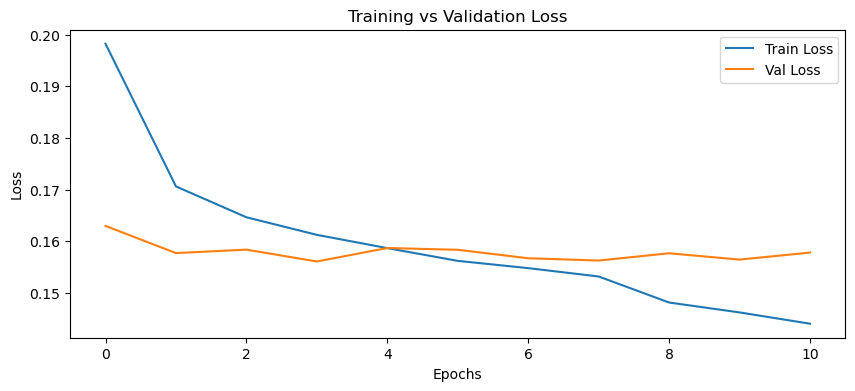

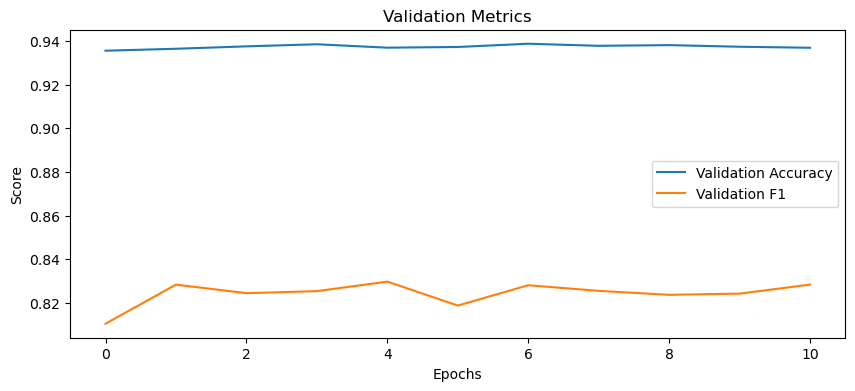

In [80]:
#plot training curves 

plt.figure(figsize=(10,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.plot(history["val_f1"], label="Validation F1")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.title("Validation Metrics")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0      0.958     0.963     0.960     23027
           1      0.828     0.811     0.819      5113

    accuracy                          0.935     28140
   macro avg      0.893     0.887     0.890     28140
weighted avg      0.935     0.935     0.935     28140



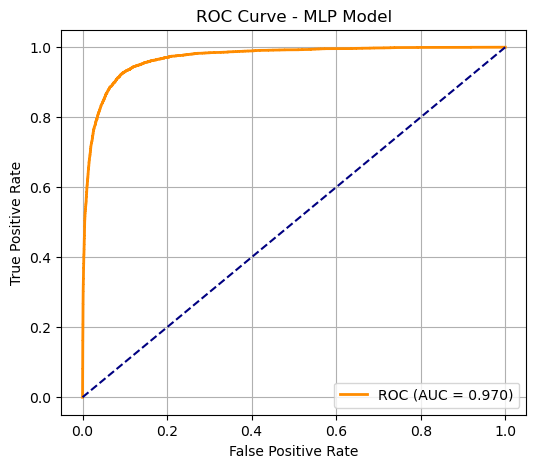

AUC Score: 0.9699


In [165]:
# Get predicted probabilities on validation set
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    y_probs = model(X_val_tensor.to(device)).cpu().numpy()
y_preds = (y_probs >= 0.5).astype(int)

# Evaluate
print("Classification Report:")
print(classification_report(y_val, y_preds, digits=3))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
auc = roc_auc_score(y_val, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC Score: {auc:.4f}")

In [81]:
import joblib

# Save model weights
torch.save(model.state_dict(), "mlp_depression_model.pth")

# Save preprocessing components
joblib.dump(preprocessor, "preprocessor.pkl")   # ColumnTransformer (includes scaler + OneHotEncoder)

# Save target feature order for safety
joblib.dump(df.columns.tolist(), "feature_columns.pkl")

print("✅ Model and preprocessing pipeline saved successfully!")


✅ Model and preprocessing pipeline saved successfully!
